In [1]:
import os
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # specify gpu to run the model if available
torch.backends.cudnn.benchmark = True  # find the suitable convolution algorithm to speed up the calculation

# Task # 1

Build an autoencoder (with at least 4 encoding layers) for a dataset of 500
grayscale natural images of size 600 × 600.

In [2]:
EPOCHS = 20
BATCH_SIZE = 20

In [3]:
import torch
import torch.nn as nn

# network structure like U-Net
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.feature = nn.Sequential(  # (b, 1, 600, 600)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=5),  # (b, 32, 120, 120)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3)  # (b, 64, 40, 40)
        )
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (b, 128, 20, 20)
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (b, 256, 10, 10)
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (b, 256, 5, 5)
        )
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # (b, 256, 10, 10)
        )
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(in_channels=256 + 256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # (b, 128, 20, 20)
        )
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(in_channels=128 + 128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # (b, 64, 40, 40)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True),  # (b, 32, 120, 120)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=5, mode='bilinear', align_corners=True),  # (b, 32, 600, 600)
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),  # (b, 1, 600, 600)
            nn.Sigmoid()  # limit the range of tensors (images) in [0,1]
        )
        
    def forward(self, x):
        x = self.feature(x)

        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        
        x4 = self.decoder_1(x3)
        x5 = self.decoder_2(torch.cat((x2, x4), dim=1))
        x6 = self.decoder_3(torch.cat((x1, x5), dim=1))

        x = self.upsample(x6)
        return x

In [4]:
# test the network
x = torch.rand(2, 1, 600, 600)
net = AutoEncoder()
print(net(x).shape)  # expected output size: [2, 1, 600, 600]

torch.Size([2, 1, 600, 600])


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# use image augmentation to broad the training data
train_transform = transforms.Compose([
    transforms.Resize(600),  # resize the image to 600 on the shortest axis
    transforms.RandomAffine(10),  # random rotation within ±10 degree
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # random change rate within ±10% of these color attributes
    transforms.RandomCrop(600),  # crop a 600x600 image from a random position
    transforms.Grayscale(),  # change the image in a grayscale
    transforms.ToTensor()  # change the image in range of [0,1] and shape of (channel, height, width)
])

# load dataset from the folder
train_dataset = ImageFolder('./datasets/DIV2K/train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=10)

# no need to augment the validation data, only basic transform is necessary
valid_transform = transforms.Compose([
    transforms.Resize(600),
    transforms.CenterCrop(600),  # crop a 600x600 image from the center
    transforms.Grayscale(),
    transforms.ToTensor()
])

valid_dataset = ImageFolder('./datasets/DIV2K/valid', transform=valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=True, num_workers=10)

print("train: {}/{} valid: {}/{}".format(len(train_dataset), len(train_loader), len(valid_dataset), len(valid_loader)))

train: 800/40 valid: 100/5


In [6]:
net = AutoEncoder().to(device)  # init the network and put into device
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # init the optimizer
loss_func = nn.L1Loss()  # use MAE as the loss function, usually used in comparing similarity of images

# set the path to save trained weights
weights_save_path = './weights'
if not os.path.exists(weights_save_path):
    os.makedirs(weights_save_path)

TRAIN: [Epoch 1/20] [Batch 10/40] [loss: 0.142719]
TRAIN: [Epoch 1/20] [Batch 20/40] [loss: 0.131764]
TRAIN: [Epoch 1/20] [Batch 30/40] [loss: 0.124821]
TRAIN: [Epoch 1/20] [Batch 40/40] [loss: 0.121376]


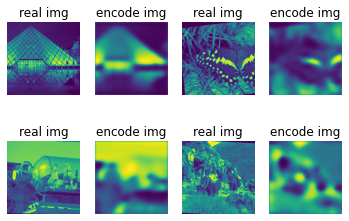

VALID: [Epoch 1/20] [Batch 5/5] [loss: 0.109601]


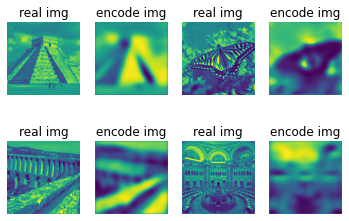

TRAIN: [Epoch 2/20] [Batch 10/40] [loss: 0.102140]
TRAIN: [Epoch 2/20] [Batch 20/40] [loss: 0.099016]
TRAIN: [Epoch 2/20] [Batch 30/40] [loss: 0.098814]
TRAIN: [Epoch 2/20] [Batch 40/40] [loss: 0.099055]


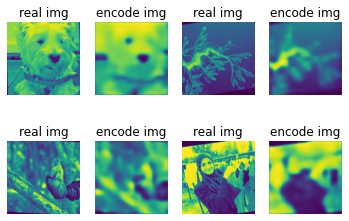

VALID: [Epoch 2/20] [Batch 5/5] [loss: 0.099480]


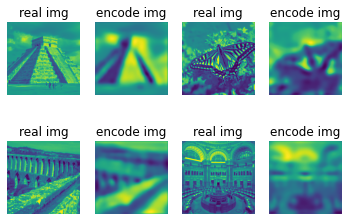

TRAIN: [Epoch 3/20] [Batch 10/40] [loss: 0.098154]
TRAIN: [Epoch 3/20] [Batch 20/40] [loss: 0.096840]
TRAIN: [Epoch 3/20] [Batch 30/40] [loss: 0.095868]
TRAIN: [Epoch 3/20] [Batch 40/40] [loss: 0.094946]


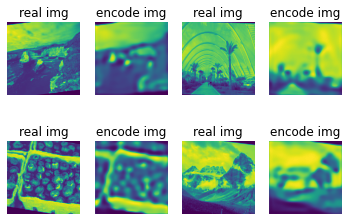

VALID: [Epoch 3/20] [Batch 5/5] [loss: 0.091505]


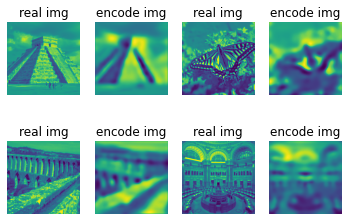

TRAIN: [Epoch 4/20] [Batch 10/40] [loss: 0.090422]
TRAIN: [Epoch 4/20] [Batch 20/40] [loss: 0.091510]
TRAIN: [Epoch 4/20] [Batch 30/40] [loss: 0.090578]
TRAIN: [Epoch 4/20] [Batch 40/40] [loss: 0.090905]


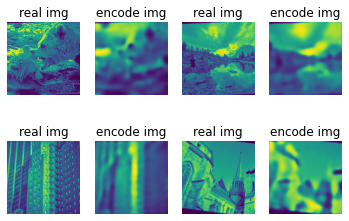

VALID: [Epoch 4/20] [Batch 5/5] [loss: 0.093921]


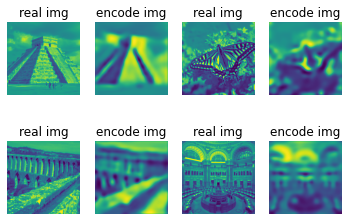

TRAIN: [Epoch 5/20] [Batch 10/40] [loss: 0.088310]
TRAIN: [Epoch 5/20] [Batch 20/40] [loss: 0.090131]
TRAIN: [Epoch 5/20] [Batch 30/40] [loss: 0.089736]
TRAIN: [Epoch 5/20] [Batch 40/40] [loss: 0.090080]


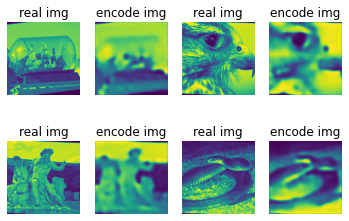

VALID: [Epoch 5/20] [Batch 5/5] [loss: 0.092641]


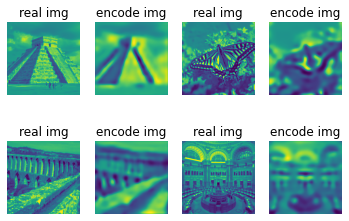

TRAIN: [Epoch 6/20] [Batch 10/40] [loss: 0.088885]
TRAIN: [Epoch 6/20] [Batch 20/40] [loss: 0.086789]
TRAIN: [Epoch 6/20] [Batch 30/40] [loss: 0.086276]
TRAIN: [Epoch 6/20] [Batch 40/40] [loss: 0.085614]


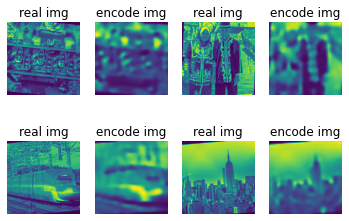

VALID: [Epoch 6/20] [Batch 5/5] [loss: 0.087848]


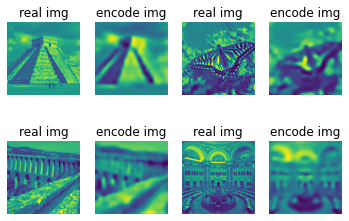

TRAIN: [Epoch 7/20] [Batch 10/40] [loss: 0.090866]
TRAIN: [Epoch 7/20] [Batch 20/40] [loss: 0.087982]
TRAIN: [Epoch 7/20] [Batch 30/40] [loss: 0.087274]
TRAIN: [Epoch 7/20] [Batch 40/40] [loss: 0.087120]


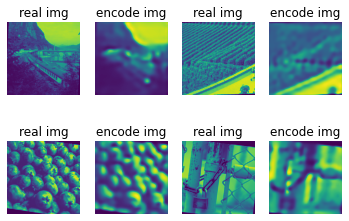

VALID: [Epoch 7/20] [Batch 5/5] [loss: 0.092761]


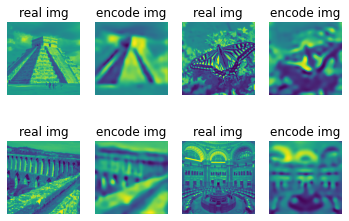

TRAIN: [Epoch 8/20] [Batch 10/40] [loss: 0.085454]
TRAIN: [Epoch 8/20] [Batch 20/40] [loss: 0.085721]
TRAIN: [Epoch 8/20] [Batch 30/40] [loss: 0.085048]
TRAIN: [Epoch 8/20] [Batch 40/40] [loss: 0.084580]


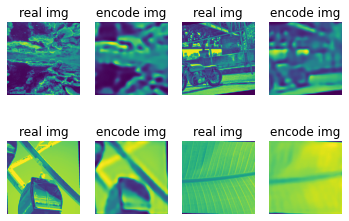

VALID: [Epoch 8/20] [Batch 5/5] [loss: 0.083972]


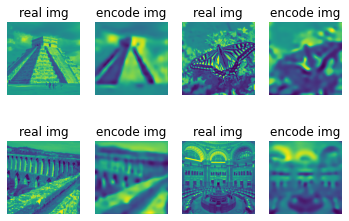

TRAIN: [Epoch 9/20] [Batch 10/40] [loss: 0.084899]
TRAIN: [Epoch 9/20] [Batch 20/40] [loss: 0.084158]
TRAIN: [Epoch 9/20] [Batch 30/40] [loss: 0.085058]
TRAIN: [Epoch 9/20] [Batch 40/40] [loss: 0.084797]


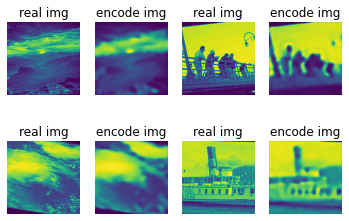

VALID: [Epoch 9/20] [Batch 5/5] [loss: 0.085088]


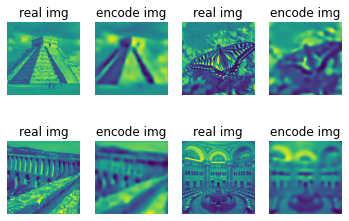

TRAIN: [Epoch 10/20] [Batch 10/40] [loss: 0.088247]
TRAIN: [Epoch 10/20] [Batch 20/40] [loss: 0.086953]
TRAIN: [Epoch 10/20] [Batch 30/40] [loss: 0.085562]
TRAIN: [Epoch 10/20] [Batch 40/40] [loss: 0.085753]


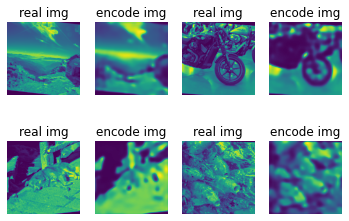

VALID: [Epoch 10/20] [Batch 5/5] [loss: 0.084557]


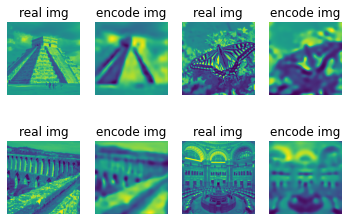

TRAIN: [Epoch 11/20] [Batch 10/40] [loss: 0.081166]
TRAIN: [Epoch 11/20] [Batch 20/40] [loss: 0.081547]
TRAIN: [Epoch 11/20] [Batch 30/40] [loss: 0.081685]
TRAIN: [Epoch 11/20] [Batch 40/40] [loss: 0.082462]


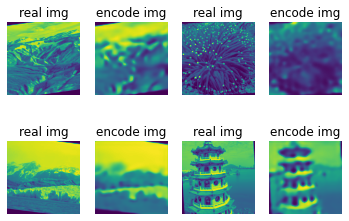

VALID: [Epoch 11/20] [Batch 5/5] [loss: 0.088770]


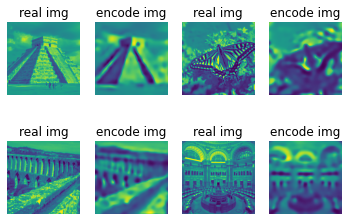

TRAIN: [Epoch 12/20] [Batch 10/40] [loss: 0.086347]
TRAIN: [Epoch 12/20] [Batch 20/40] [loss: 0.088127]
TRAIN: [Epoch 12/20] [Batch 30/40] [loss: 0.085982]
TRAIN: [Epoch 12/20] [Batch 40/40] [loss: 0.084806]


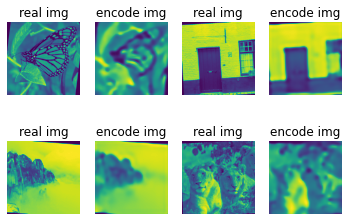

VALID: [Epoch 12/20] [Batch 5/5] [loss: 0.088424]


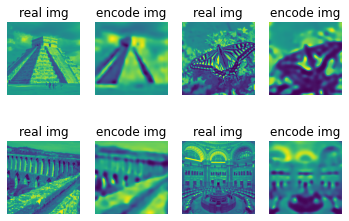

TRAIN: [Epoch 13/20] [Batch 10/40] [loss: 0.081309]
TRAIN: [Epoch 13/20] [Batch 20/40] [loss: 0.081034]
TRAIN: [Epoch 13/20] [Batch 30/40] [loss: 0.080938]
TRAIN: [Epoch 13/20] [Batch 40/40] [loss: 0.080923]


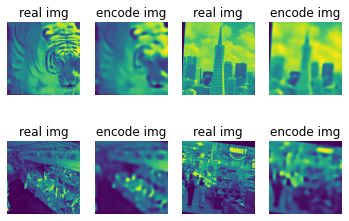

VALID: [Epoch 13/20] [Batch 5/5] [loss: 0.082336]


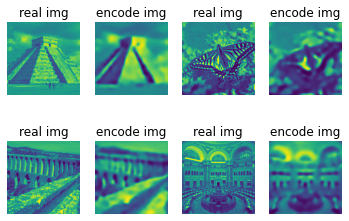

TRAIN: [Epoch 14/20] [Batch 10/40] [loss: 0.080052]
TRAIN: [Epoch 14/20] [Batch 20/40] [loss: 0.079527]
TRAIN: [Epoch 14/20] [Batch 30/40] [loss: 0.080304]
TRAIN: [Epoch 14/20] [Batch 40/40] [loss: 0.080500]


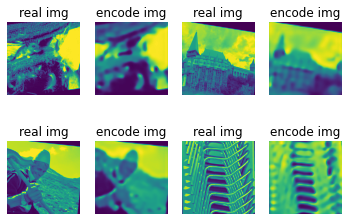

VALID: [Epoch 14/20] [Batch 5/5] [loss: 0.079756]


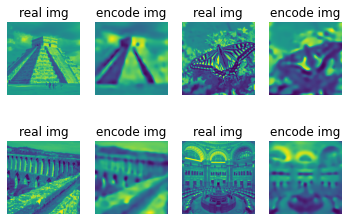

TRAIN: [Epoch 15/20] [Batch 10/40] [loss: 0.082416]
TRAIN: [Epoch 15/20] [Batch 20/40] [loss: 0.081657]
TRAIN: [Epoch 15/20] [Batch 30/40] [loss: 0.082042]
TRAIN: [Epoch 15/20] [Batch 40/40] [loss: 0.082073]


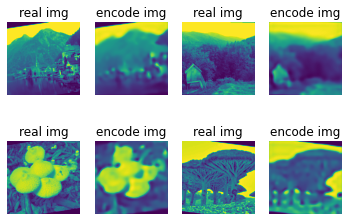

VALID: [Epoch 15/20] [Batch 5/5] [loss: 0.087115]


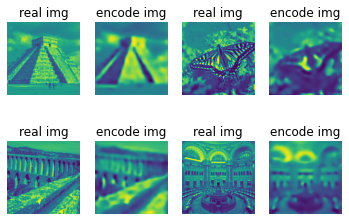

TRAIN: [Epoch 16/20] [Batch 10/40] [loss: 0.080257]
TRAIN: [Epoch 16/20] [Batch 20/40] [loss: 0.079450]
TRAIN: [Epoch 16/20] [Batch 30/40] [loss: 0.079451]
TRAIN: [Epoch 16/20] [Batch 40/40] [loss: 0.078758]


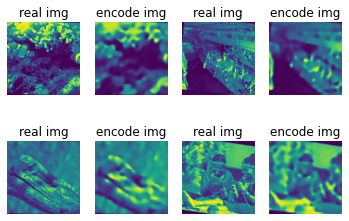

VALID: [Epoch 16/20] [Batch 5/5] [loss: 0.081191]


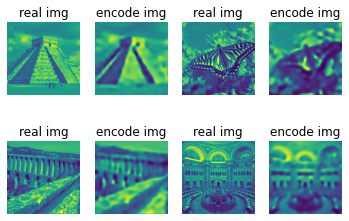

TRAIN: [Epoch 17/20] [Batch 10/40] [loss: 0.078554]
TRAIN: [Epoch 17/20] [Batch 20/40] [loss: 0.078582]
TRAIN: [Epoch 17/20] [Batch 30/40] [loss: 0.079198]
TRAIN: [Epoch 17/20] [Batch 40/40] [loss: 0.079600]


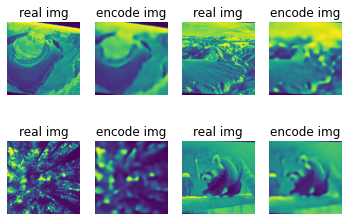

VALID: [Epoch 17/20] [Batch 5/5] [loss: 0.079193]


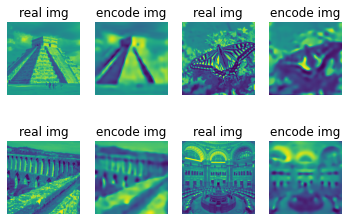

TRAIN: [Epoch 18/20] [Batch 10/40] [loss: 0.080123]
TRAIN: [Epoch 18/20] [Batch 20/40] [loss: 0.076595]
TRAIN: [Epoch 18/20] [Batch 30/40] [loss: 0.077720]
TRAIN: [Epoch 18/20] [Batch 40/40] [loss: 0.077994]


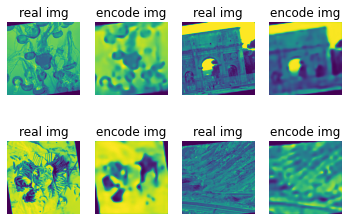

VALID: [Epoch 18/20] [Batch 5/5] [loss: 0.079899]


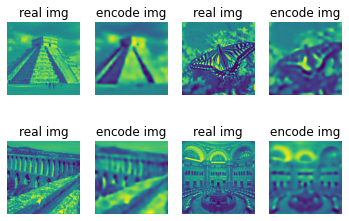

TRAIN: [Epoch 19/20] [Batch 10/40] [loss: 0.078534]
TRAIN: [Epoch 19/20] [Batch 20/40] [loss: 0.078366]
TRAIN: [Epoch 19/20] [Batch 30/40] [loss: 0.079031]
TRAIN: [Epoch 19/20] [Batch 40/40] [loss: 0.079277]


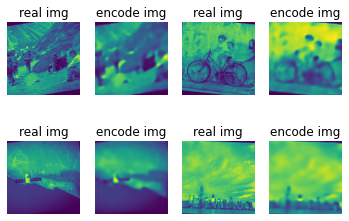

VALID: [Epoch 19/20] [Batch 5/5] [loss: 0.089404]


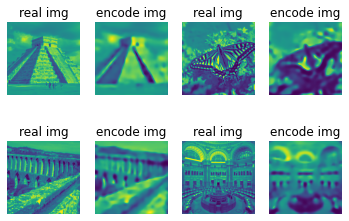

TRAIN: [Epoch 20/20] [Batch 10/40] [loss: 0.080532]
TRAIN: [Epoch 20/20] [Batch 20/40] [loss: 0.079748]
TRAIN: [Epoch 20/20] [Batch 30/40] [loss: 0.080301]
TRAIN: [Epoch 20/20] [Batch 40/40] [loss: 0.079907]


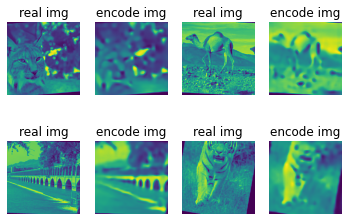

VALID: [Epoch 20/20] [Batch 5/5] [loss: 0.077254]


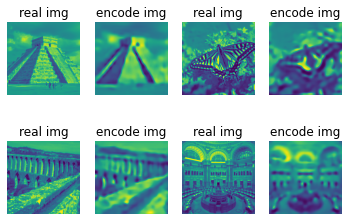

In [7]:
# training process
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


min_loss = float("inf")
for epoch in range(EPOCHS):
    net.train()  # set net into train mode
    train_loss = []
    for batch_idx, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)  # put data into device
        pred = net(imgs)  # get the output
        loss = loss_func(imgs, pred)  # get the loss

        optimizer.zero_grad()  # clear the optimizer
        loss.backward()  # calculate the gradients from the loss backward to the input
        optimizer.step()  # optimizer updates the parameters of model

        train_loss.append(loss.cpu().detach().numpy())
        
        if (batch_idx+1) % 10 == 0:
            print("TRAIN: [Epoch %d/%d] [Batch %d/%d] [loss: %f]" % (
                epoch+1, EPOCHS, batch_idx+1, len(train_loader), np.mean(train_loss)))
    
    # visualize some results
    for i in range(4):
        plt.subplot(2, 4, 2*i+1)
        plt.axis("off")
        plt.title('real img')
        plt.imshow(imgs[i].squeeze().cpu().detach().numpy())
        plt.subplot(2, 4, 2*i+2)
        plt.axis("off")
        plt.title('encode img')
        plt.imshow(pred[i].squeeze().cpu().detach().numpy())
    plt.show()

    # validation process
    net.eval()  # set net into evaluation mode to freeze the batchnorm
    valid_loss = []
    with torch.no_grad():  # save the calculation time and memory without gradients
        for batch_idx, (imgs, _) in enumerate(valid_loader):
            imgs = imgs.to(device)
            pred = net(imgs)
            valid_loss.append(loss_func(imgs, pred).cpu())

    print("VALID: [Epoch %d/%d] [Batch %d/%d] [loss: %f]" % (
        epoch+1, EPOCHS, batch_idx+1, len(valid_loader), np.mean(valid_loss)))
    
    if np.mean(valid_loss) < min_loss:  # save when the validation loss is a current minima
        torch.save(net.state_dict(), '{}/autoencoder.pth'.format(weights_save_path))  # save the network weights
        torch.save(optimizer.state_dict(), '{}/optimizer_ae.pth'.format(weights_save_path))  # save the optimizer parameters
        min_loss = np.mean(valid_loss)
    
    for i in range(4):
        plt.subplot(2, 4, 2*i+1)
        plt.axis("off")
        plt.title('real img')
        plt.imshow(imgs[i].squeeze().cpu().detach().numpy())
        plt.subplot(2, 4, 2*i+2)
        plt.axis("off")
        plt.title('encode img')
        plt.imshow(pred[i].squeeze().cpu().detach().numpy())
    plt.show()
    
    print('=' * 40)

In [ ]:
import numpy as np
# To finally test the model, reload the weights and test it

net.load_state_dict(torch.load('{}/autoencoder.pth'.format(weights_save_path), map_location=device))

# test process
net.eval()
test_loss = []
with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(valid_loader):  # use the test data from real world or test set
        imgs = imgs.to(device)
        pred = net(imgs)
        test_loss.append(loss_func(imgs, pred).cpu())

print("[loss: %f]" % (np.mean(test_loss)))

[loss: 0.116229]


# Task # 2

Take 1000 images from CIFAR10. Then, given a pair of images from CIFAR10
x1 and x2, build a network that can return both images given their average
(x1+x2)/2 as the only input. The design of the architecture and of the input-output mapping is your choice.

In [2]:
EPOCHS = 2
BATCH_SIZE = 100

In [3]:
import torch
import torch.nn as nn

# define a residual block as ResNet-pytorch
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


# use residual feature extractor
class ResBlock(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResBlock, self).__init__()
        self.in_planes = 64

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)  # (b, 64, 32, 32)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)  # (b, 128, 32, 32)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)  # (b, 256, 32, 32)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)  # (b, 512, 32, 32)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


# network structure
class MergeSplit(nn.Module):
    def __init__(self):
        super(MergeSplit, self).__init__()  # (b, 3, 32, 32)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)  # (b, 64, 32, 32)

        self.branch1 = ResBlock(BasicBlock, [1,1,1,1])  # (b, 512, 32, 32)
        self.conv_b1 = nn.Conv2d(in_channels=512, out_channels=3, kernel_size=3, stride=1, padding=1)  # (b, 3, 32, 32)
        
        self.branch2 = ResBlock(BasicBlock, [1,1,1,1])  # (b, 512, 32, 32)
        self.conv_b2 = nn.Conv2d(in_channels=512, out_channels=3, kernel_size=3, stride=1, padding=1)  # (b, 3, 32, 32)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x1 = self.branch1(x)
        x1 = self.sigmoid(self.conv_b1(x1))

        x2 = self.branch2(x)
        x2 = self.sigmoid(self.conv_b2(x2))
        return x1, x2

In [4]:
# test the network
x = torch.rand(2, 3, 32, 32)
net = MergeSplit()
print(net(x)[0].shape)
print(net(x)[1].shape)  # expected output size: (x1, x2) [2, 3, 32, 32]

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])


In [5]:
# load dataset

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])
train_dataset = CIFAR10(root='./datasets', train=True, transform=train_transform)
# indices = range(4)
# train_dataset = torch.utils.data.Subset(train_dataset, indices)
train_loader_1 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=10)
train_loader_2 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=10)

valid_transform = transforms.Compose([
    transforms.ToTensor()
])
valid_dataset = CIFAR10(root='./datasets', train=False, transform=valid_transform)
# indices = range(4)
# valid_dataset = torch.utils.data.Subset(valid_dataset, indices)
valid_loader_1 = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, pin_memory=True, num_workers=10)
valid_loader_2 = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, pin_memory=True, num_workers=10)

print("train: {}/{} valid: {}/{}".format(len(train_dataset), len(train_loader_1), len(valid_dataset), len(valid_loader_1)))

train: 50000/500 valid: 10000/100


In [6]:
net = MergeSplit().to(device)  # init the network
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # init the optimizer
loss_func = nn.L1Loss()  # use MAE as the loss function

weights_save_path = './weights'
if not os.path.exists(weights_save_path):
    os.makedirs(weights_save_path)

TRAIN: [Epoch 1/2] [Batch 100/500] [loss: 0.662178]


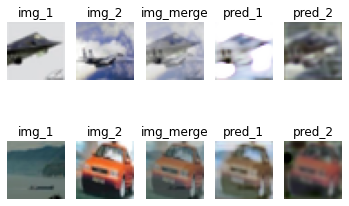

TRAIN: [Epoch 1/2] [Batch 200/500] [loss: 0.621417]


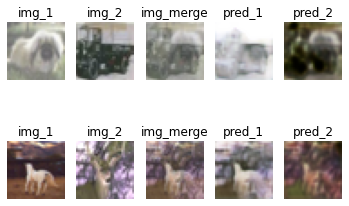

TRAIN: [Epoch 1/2] [Batch 300/500] [loss: 0.604966]


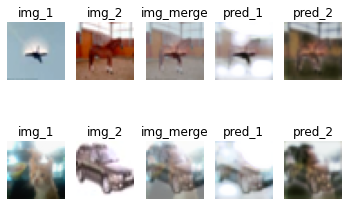

TRAIN: [Epoch 1/2] [Batch 400/500] [loss: 0.594988]


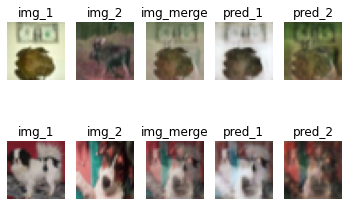

TRAIN: [Epoch 1/2] [Batch 500/500] [loss: 0.587014]


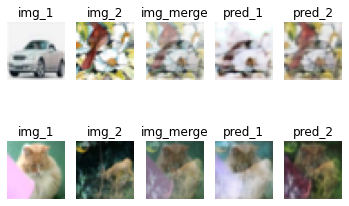

VALID: [Epoch 1/2] [Batch 100/100] [loss: 0.561608]


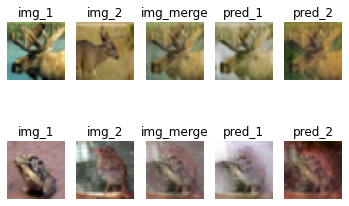

TRAIN: [Epoch 2/2] [Batch 100/500] [loss: 0.554606]


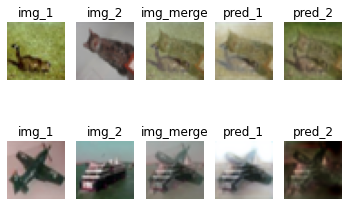

TRAIN: [Epoch 2/2] [Batch 200/500] [loss: 0.549943]


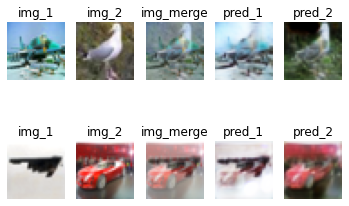

TRAIN: [Epoch 2/2] [Batch 300/500] [loss: 0.548433]


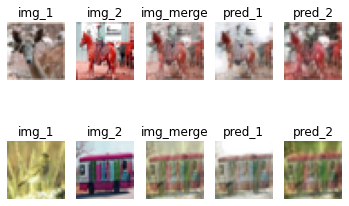

TRAIN: [Epoch 2/2] [Batch 400/500] [loss: 0.545707]


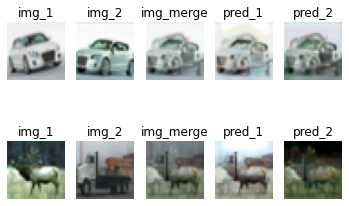

TRAIN: [Epoch 2/2] [Batch 500/500] [loss: 0.545219]


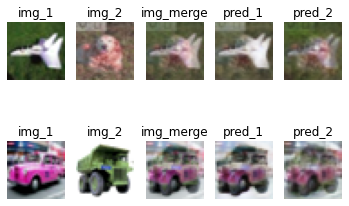

VALID: [Epoch 2/2] [Batch 100/100] [loss: 0.575573]


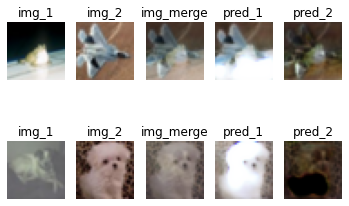

In [7]:
# training process
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F



min_loss = float("inf")
for epoch in range(EPOCHS):
    net.train()
    train_loss = []
    for batch_idx, (imgs, _) in enumerate(train_loader_1):
        img_1 = imgs.to(device)
        img_2 = next(iter(train_loader_2))[0].to(device)  # one sample is got from train_loader_1, meanwhile from train_loader_2
        
        img_merge = 0.5 * (img_1 + img_2)  # (x1+x2)/2

        pred_1, pred_2 = net(img_merge)

        # distance: (pred_1, pred_2) = (x_1, x_2)， (pred_merge, x_merge) = 0
        # direction of connected line_: (pred_1, pred_2) = (x_1, x_2)
        parallelism = torch.mean(1 - torch.abs(F.cosine_similarity((img_1-img_2).view(-1, 3*32*32), (pred_1-pred_2).view(-1, 3*32*32), dim=1)))
        loss = torch.abs(loss_func(img_1, img_2) - loss_func(pred_1, pred_2)) + loss_func(0.5 * (pred_1 + pred_2), img_merge) + parallelism

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
        
        if (batch_idx+1) % 100 == 0:
            print("TRAIN: [Epoch %d/%d] [Batch %d/%d] [loss: %f]" % (
                epoch+1, EPOCHS, batch_idx+1, len(train_loader_1), np.mean(train_loss)))
    
            for i in range(2):
                plt.subplot(2, 5, 5*i+1)
                plt.axis("off")
                plt.title('img_1')
                plt.imshow(img_1[i].permute(1,2,0).cpu().detach().numpy())

                plt.subplot(2, 5, 5*i+2)
                plt.axis("off")
                plt.title('img_2')
                plt.imshow(img_2[i].permute(1,2,0).cpu().detach().numpy())

                plt.subplot(2, 5, 5*i+3)
                plt.axis("off")
                plt.title('img_merge')
                plt.imshow(img_merge[i].permute(1,2,0).cpu().detach().numpy())

                plt.subplot(2, 5, 5*i+4)
                plt.axis("off")
                plt.title('pred_1')
                plt.imshow(pred_1[i].permute(1,2,0).cpu().detach().numpy())

                plt.subplot(2, 5, 5*i+5)
                plt.axis("off")
                plt.title('pred_2')
                plt.imshow(pred_2[i].permute(1,2,0).cpu().detach().numpy())
            plt.show()

    # validation process
    net.eval()
    valid_loss = []
    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(valid_loader_1):
            img_1 = imgs.to(device)
            img_2 = next(iter(valid_loader_2))[0].to(device)
            img_merge = 0.5 * (img_1 + img_2)

            pred_1, pred_2 = net(img_merge)
            parallelism = torch.mean(1 - torch.abs(F.cosine_similarity((img_1-img_2).view(-1, 3*32*32), (pred_1-pred_2).view(-1, 3*32*32), dim=1)))
            loss = torch.abs(loss_func(img_1, img_2) - loss_func(pred_1, pred_2)) + loss_func(0.5 * (pred_1 + pred_2), img_merge) + parallelism
            valid_loss.append(loss.cpu())

    print("VALID: [Epoch %d/%d] [Batch %d/%d] [loss: %f]" % (
        epoch+1, EPOCHS, batch_idx+1, len(valid_loader_1), np.mean(valid_loss)))
    
    if np.mean(valid_loss) < min_loss:  # save when the validation loss is a current minima
        torch.save(net.state_dict(), '{}/mergesplit.pth'.format(weights_save_path))
        torch.save(optimizer.state_dict(), '{}/optimizer_ms.pth'.format(weights_save_path))
        min_loss = np.mean(valid_loss)
    
    for i in range(2):
        plt.subplot(2, 5, 5*i+1)
        plt.axis("off")
        plt.title('img_1')
        plt.imshow(img_1[i].permute(1,2,0).cpu().detach().numpy())

        plt.subplot(2, 5, 5*i+2)
        plt.axis("off")
        plt.title('img_2')
        plt.imshow(img_2[i].permute(1,2,0).cpu().detach().numpy())

        plt.subplot(2, 5, 5*i+3)
        plt.axis("off")
        plt.title('img_merge')
        plt.imshow(img_merge[i].permute(1,2,0).cpu().detach().numpy())

        plt.subplot(2, 5, 5*i+4)
        plt.axis("off")
        plt.title('pred_1')
        plt.imshow(pred_1[i].permute(1,2,0).cpu().detach().numpy())

        plt.subplot(2, 5, 5*i+5)
        plt.axis("off")
        plt.title('pred_2')
        plt.imshow(pred_2[i].permute(1,2,0).cpu().detach().numpy())
    plt.show()

    print('=' * 40)

In [ ]:
import numpy as np
# To finally test the model, reload the weights and test it

net = MergeSplit().to(device)
net.load_state_dict(torch.load('{}/mergesplit.pth'.format(weights_save_path), map_location=device))

# test process
net.eval()
test_loss = []
with torch.no_grad():
    for batch_idx, (imgs, _) in enumerate(valid_loader_1):
        img_1 = imgs.to(device)
        img_2 = next(iter(valid_loader_2))[0].to(device)
        img_merge = 0.5 * (img_1 + img_2)

        pred_1, pred_2 = net(img_merge)
        loss = loss_func(img_1, pred_1) + loss_func(img_2, pred_2)
        test_loss.append(loss.cpu())

        if batch_idx > 2:
            break

print("[loss: %f]" % (np.mean(test_loss)))

[loss: 0.231697]


In [ ]:
!jupyter nbconvert --to html *.ipynb

[NbConvertApp] Converting notebook task 2022.ipynb to html
[NbConvertApp] Writing 1179882 bytes to task 2022.html
